Simple CNN for notMNIST with Decoupled Training/Testing Phases
=============
In cnn-1, the network was created, trained, tested, and then scrapped--all in a single TensorFlow session.  In this version, the network will be trained in a pausable session and all the information needed to rebuild it will be saved.  Then it will be tested in a separate session.  This kind of separation is obviously necessary for doing anything serious with a network (like submitting it for a Kaggle competition).

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

## Input Data

In [2]:
pickle_file = '../notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)

Training set (200000, 28, 28) (200000,)


### Preprocessing $\cdot$ Normalization

Apparently, these networks learn better if the input data (the pixel values, in this context) have a mean of 0 and a variance of 1 [citation needed].  So, we want to adjust the pixel values a bit before we dump them into the machine.  In a future worksheet we'll also compute and subtract the mean *image* (i.e. given pixel coordiates i,j find the mean value of pixel (i,j) across all images in the dataset; do this for each i,j).

Let $K = N \times H \times W$, where $N$ is the number of images, $H$ is the height of each image, and $W$ is the width.  Let $x_1, x_2, \ldots, x_K$ be the big list of all the pixel values from all the training images.

Getting a mean of 0 is easy.  Just compute the mean $\mu$ of the pixels in the training data and subtract that from each of them.  We'll also need treat that $\mu$ as an estimator of the mean of our other datasets and subtract it from them too.  

But how do we get varianace 1?  Well, after that first step, our new pixel values will be $x_i' = (x_i-\mu)$.  We can adjust the variance of those pixels by scaling them.  So, we're looking for a scalar $c$ that will make those values $c(x_i-\mu)$ have a variance of 1.  The variance of these adjusted pixels is given by this expression (where $\sigma^2$ is the variance of the original pixels):

$$\begin{eqnarray}
\sum_1^N \left(c \left(x_i - \mu\right)\right)^2
&=& c^2 \sum_1^N \left(x_i - \mu\right)^2\\
&=& c^2 \sigma^2\\
\end{eqnarray}$$

So, there you go.  Our scalar $c = \frac 1 \sigma$.

In [3]:
# Find mean and std. dev. of training data
mu = np.mean(train_dataset)
sigma = np.std(train_dataset)
print('mu = %f, sigma = %f' % (mu, sigma))

# Normalize dataset
train_dataset = (train_dataset - mu) / sigma

mu = -0.081865, sigma = 0.454264


#### Sanity Check

Let's see a histogram of those pixel values.

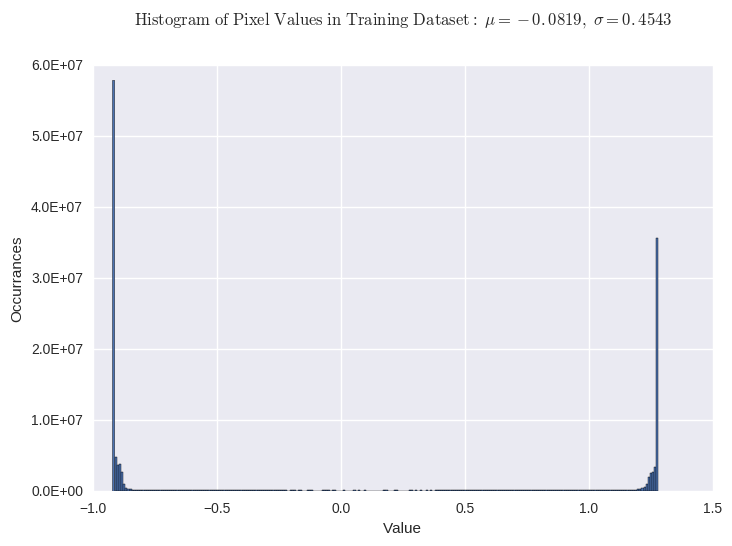

In [4]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

# the histogram of the data
n, bins, patches = plt.hist(train_dataset.flatten(), 256)

# The default y-tick labels are bizarre when y values are large
ax = plt.gca()
y_tick_labels = list(map((lambda t: "%.1E" % t), ax.get_yticks()))
ax.set_yticklabels(y_tick_labels)

plt.xlabel('Value')
plt.ylabel('Occurrances')

# The "r" prefix here means "raw mode" (don't treat \ as an escape)
# The "y=1.08" parameter prevents the title from overlapping with the chart
plt.title(r'$\mathrm{Histogram\ of\ Pixel\ Values\ in\ Training\ Dataset:}\ \mu= %.4f,\ \sigma=%.4f$' % (mu,sigma), y=1.08)
plt.show()

As one would guess from looking the pictures in the dataset, they're greyscale but almost completely monochromatic.  Take this, one, say...

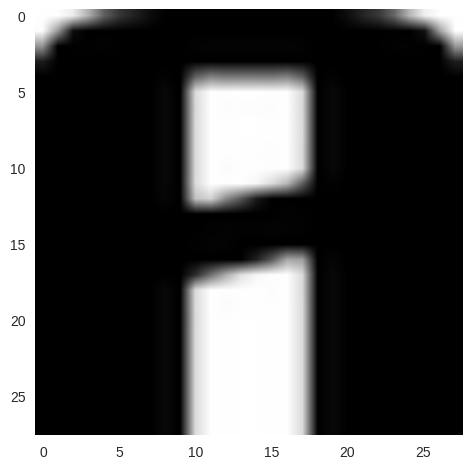

In [5]:
# Pick a random image from the training dataset
i = np.random.randint(train_dataset.shape[0])
im = train_dataset[i,:,:]
plt.grid(False)
plt.imshow(im)
plt.show()

#### Save Normalization Constants

In cnn-1, we did all the training and testing together, so we could normalize all the datasets at once.

In this worksheet, we can't do that because the training and testing phases are decoupled.  We need to save the $\mu$ and $\sigma$ we calculated for the training data and then reload them for the testing phase.  These stats aren't really part of the neural network, though; they're part of a preprocessing step.  So, we'll save them in a separate graph with a separate Saver.  

Why not get a new $\mu$ and $\sigma$ directly from the testing data?

Two reasons.  Firstly, those values from the training data form a "lens" through the which the network was trained to see input (it wasn't trained using the mean and std.dev. of the testing data).  Secondly, that would be "cheating."  In a real-time application, it would not even possible to compute these statistics of the testing data.

In [6]:
g = tf.Graph()
with g.as_default():
    tf_mu = tf.Variable(name="tf_mu", dtype=tf.float32, initial_value=mu)
    tf_sigma = tf.Variable(name="tf_sigma", dtype=tf.float32, initial_value=sigma)
with tf.Session(graph=g) as s:
    tf.global_variables_initializer().run()
    metadata_saver = tf.train.Saver(var_list=[tf_mu, tf_sigma])
    metadata_saver.save(s, '/tmp/cnn-2-stats.tfsaver')

### Preprocessing: Reformat data into a TensorFlow-friendly shapes
- The design matrix is currently N x H x W, since they're greyscale images (no channel dimension like you'd get with colour images).  tf.nn.conv2d needs them formatted as N x H x W x #channels, however.  So we need to add a dimension at the end of the shape vector for the input data.
- Labels need to be one-hot encoded floats.

In [7]:
def one_hot_encode(labels, num_categories):
    '''Converts an array of labels to an array of one-hot-encoded labels.
    [NB: Just noticed there's now a "tf.one_hot" function.  Should switch to that.]
    Args:
        labels: list (row vector) of N labels (where N is the number of examples)
        num_categories: the number of possible labels
    Returns:
        N x num_categories array of one-hot encoded labels
    '''
    # IMPLEMENTATION
    # np.expand_dims(labels, 1) is an Nx1 array (a.k.a. a column vector) 
    # [0..num_categories] == k is evaluated for each label k in the column vector
    # This produces a one-hot vector [false, false, ..., true, false, ..., false] where "true" is in position k
    # Then astype(float32) converts the array of booleans to an array of 0s and 1s (as floats)
    return (np.arange(num_categories) == np.expand_dims(labels, 1)).astype(np.float32)

In [8]:
# Testing one_hot_encode
pretend_labels = np.random.randint(10, size=5)
print("pretend labels = ", pretend_labels)
one_hot_encode(pretend_labels, 10)

pretend labels =  [6 8 6 7 8]


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]], dtype=float32)

In [9]:
image_size = 28  # 32 for MNIST, but we're doing notMNIST
num_labels = 10  # notMNIST is ABCDEFGHIJ, which is also 10 categories
num_channels = 1 # grayscale

with tf.name_scope("Training-Input") as scope:
    train_dataset = np.expand_dims(train_dataset, 3) # NxHxW --> NxHxWx1
    train_labels = one_hot_encode(train_labels, num_labels)
print('Training dataset\t', train_dataset.shape, "\tTraining labels\t\t", train_labels.shape)

Training dataset	 (200000, 28, 28, 1) 	Training labels		 (200000, 10)


## The Computation Graph

### Hyperparameters

In [10]:
with tf.name_scope("Hyperparameters") as scope:
    batch_size = 16
    patch_size = 5    # kernel 
    depth = 16        # depth of first hidden layer
    num_hidden = 64

### Create Graph and Set Up Placeholder Nodes in GPU Memory for the Input Data

In [11]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('Training-Input-Data'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
        tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))

### Allocate and Initialize All Weights and Biases
We'll use tf.get_variable instead of tf.Variable to make it easier for multi-GPU runs. 

In [12]:
with graph.as_default():
    
    # First Conv Layer
    with tf.variable_scope('ConvPoolRelu1'):
        weights = tf.get_variable(name = "weights", 
                                  shape = (patch_size, patch_size, num_channels, depth), 
                                  initializer = tf.truncated_normal_initializer(mean = 0, 
                                                                               stddev = 0.1, 
                                                                               seed = None), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (depth),
                                 initializer = tf.constant_initializer(0),
                                 dtype = tf.float32)
    # Second Conv Layer
    with tf.variable_scope('ConvPoolRelu2'):  
        weights = tf.get_variable(name = "weights", 
                                  shape = (patch_size, patch_size, depth, depth), 
                                  initializer = tf.truncated_normal_initializer(mean = 0, 
                                                                               stddev = 0.1, 
                                                                               seed = None), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (depth),
                                 initializer = tf.constant_initializer(0),
                                 dtype = tf.float32)
    # First Fully-Connected Layer
    with tf.variable_scope('FullyConnected3'):
        weights = tf.get_variable(name = "weights", 
                                  shape = ((image_size//4)**2 * depth, num_hidden), 
                                  initializer = tf.truncated_normal_initializer(mean = 0, 
                                                                               stddev = 0.1, 
                                                                               seed = None), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (num_hidden),
                                 initializer = tf.constant_initializer(0),
                                 dtype = tf.float32)
    # Second Fully-Connected Layer
    with tf.variable_scope('FullyConnected4'):
        weights = tf.get_variable(name = "weights", 
                                  shape = (num_hidden, num_labels), 
                                  initializer = tf.truncated_normal_initializer(mean = 0, 
                                                                               stddev = 0.1, 
                                                                               seed = None), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (num_labels),
                                 initializer = tf.constant_initializer(0),
                                 dtype = tf.float32)

### Layer-building Functions

In [13]:
def conv_pool_relu_layer(X, W, b):
    conv_X = tf.nn.conv2d(X, W, [1, 1, 1, 1], padding='SAME')
    pool_conv_X = tf.nn.max_pool(conv_X, [1,2,2,1], [1,2,2,1], padding='SAME')
    relu_pool_conv_X = tf.nn.relu(pool_conv_X + b)
    return relu_pool_conv_X

def fc_layer(X, W, b):
    return tf.matmul(X, W) + b

def flatten_activation_map(x):
    """Converts a 4D tensor into a 2D tensor (so it can be fed to a fully-connected layer).
    Args:
        x: tensor with shape (N, H, W, C)
    Returns:
        tensor with shape (N, H*W*C)
    """
    s = x.get_shape().as_list()
    return tf.reshape(x, [s[0], -1])

### Network-assembly Function

In [14]:
def model(data):
    """Retrieves the weights and biases and constructs the computation graph with them.
    Args:
        data: A batch tensor of input examples K x H x W x D (where K is the batch size)
    Returns: the network output K x C (where C is the number of categories)
    """
    with tf.variable_scope('ConvPoolRelu1', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        layer_1_output = conv_pool_relu_layer(data, W, B)
    with tf.variable_scope('ConvPoolRelu2', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        layer_2_output = conv_pool_relu_layer(layer_1_output, W, B)
        flat_X = flatten_activation_map(layer_2_output)
    with tf.variable_scope('FullyConnected3', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        fc1_layer_output = tf.nn.relu(fc_layer(flat_X, W, B))
    with tf.variable_scope('FullyConnected4', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        fc2_layer_output = fc_layer(fc1_layer_output, W, B)
    return fc2_layer_output

### Interpret the Output, Set Up the Loss Function, Specify the Learning Algorithm 

In [15]:
with graph.as_default():
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
    tf.summary.scalar("Loss", loss)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)

### Training-related Functions

In [16]:
def accuracy(predictions, labels):
    '''
    "Grades" a list of predictions (like marking a multiple choice test).
    Accepts a list of one-hot predictions and a list of ground truth labels (the right answers) 
    Args:
        predictions: NxK float array of one-hot-encoded network output, 
                     where N is the number of examples and K is the number of categories
        labels: NxK array of one-hot-encoded ground truth labels (why one-hot encode those??)
    Returns:
        Percetage of correct predictions.
    '''
    # argmax(predictions, 1) gives the "mostly likely" category ("one-decodes" the network output)
    # argmax(labels, 1) does the same thing 
    #    Why did we even one-hot encode those to begin with??
    #    Ah... Right.  Because the loss function compares them to the network output.
    # By putting the == inside a sum, we're implicitly casting the equality test to an int.
    # Correct predictions yield 1, incorrect ones yield 0.
    # Then we divide the tally of 1s by the number of predictions in the set.
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) 
          / predictions.shape[0])

def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
        tf.summary.scalar('sttdev/' + name, stddev)
        tf.summary.scalar('max/' + name, tf.reduce_max(var))
        tf.summary.scalar('min/' + name, tf.reduce_min(var))
        tf.summary.histogram(name, var)
    
def clear_tensorboard_dir(path):
    if tf.gfile.Exists(path):
        tf.gfile.DeleteRecursively(path)
    tf.gfile.MakeDirs(path)

def make_batch(data, max_size, batch_num):
    n = data.shape[0]
    offset = (batch_num * max_size) % n
    return data[offset:offset+max_size]

## Train the Network and Save Its Parameters

In [ ]:
import time
from datetime import timedelta

num_epochs = 1

# Clear the tensorboard directory
clear_tensorboard_dir("tensorboard")

with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    merged_summaries = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./tensorboard', session.graph)
    
    # Initialize the variables on the GPU
    tf.global_variables_initializer().run()

    print('Training...')
    start_time = time.time()
    n_examples = train_dataset.shape[0]
    batches_per_epoch = int(np.ceil(n_examples / batch_size))
    for epoch in range(num_epochs):
        print('\nEpoch %d of %d' % ((epoch+1), num_epochs))
        for batch in range(batches_per_epoch):
            batch_data = make_batch(train_dataset, batch_size, batch)
            batch_labels = make_batch(train_labels, batch_size, batch)
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
            merged_sums, _, l, predictions = session.run([merged_summaries, train_op, loss, train_prediction], 
                                                         feed_dict=feed_dict)
            # Progress report
            if ((batch+1) % (batches_per_epoch // 100) == 0):
                #train_writer.add_summary(merged_sums, batch)
                print('\r-- %d%% complete --' % (100*(batch+1) // batches_per_epoch), end="")

                # Save the variables to disk.
                save_path = saver.save(session, "/tmp/model.ckpt")
                #print("Model saved in file: %s" % save_path)
            
    duration = timedelta(seconds=(time.time() - start_time))
    print('\nTrained in %s at %s per epoch' % (duration, duration / num_epochs))
    
    train_writer.close()    

Training...

Epoch 1 of 1
-- 100% complete --
Trained in 0:00:32.879681 at 0:00:32.879681 per epoch


# Testing Phase
Now, we want to **wipe memory clean** (restart the Jupyter notebook kernel) and load only the network parameters that the training session saved for us.  We also need to load up the testing data, and normalize it.

In [ ]:
# Kill the kernel, forcing it to restart - NB: You'll have to step manually from here on.
import os
os._exit(0)

## Unpickle the test data

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

pickle_file = '../notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Test set', test_dataset.shape, test_labels.shape)

Test set (18724, 28, 28) (18724,)


### Normalize
Start a session, create a saver, and use it to restore the graph so we can retrieve the $\mu$ and $\sigma$ constants.  We *could* get these in the main testing session, but it's nice to have the flexibility afforded by keeping these tasks in separate sessions (plus, the one-session way is obvious; the two-session way is challenging and useful so it has didactic value).

In [2]:
g = tf.Graph()
with g.as_default():
    tf_mu = tf.Variable(name="tf_mu", dtype=tf.float32, initial_value=0)
    tf_sigma = tf.Variable(name="tf_sigma", dtype=tf.float32, initial_value=0)
with tf.Session(graph=g) as s:
    metadata_saver = tf.train.Saver(var_list=[tf_mu, tf_sigma])
    metadata_saver.restore(s, '/tmp/cnn-2-stats.tfsaver')
    mu, sigma = s.run([tf_mu, tf_sigma])
    print("mu = %f, sigma = %f" % (mu, sigma))
    
    # Use mu and sigma as an estimator of the mean and std. dev. of the test dataset and normalize it
    test_dataset = (test_dataset - mu) / sigma

INFO:tensorflow:Restoring parameters from /tmp/cnn-2-stats.tfsaver
mu = -0.081865, sigma = 0.454264


## The Computation Graph (Again) $\cdot$ Testing Phase

### Hyperparameters

In [3]:
test_batch_size = 1000  # no need to overthink think this one; just find a size that fits on the GPU    
patch_size = 5    # kernel 
depth = 16        # depth of first hidden layer
num_hidden = 64
image_size = 28
num_channels = 1
num_labels = 10

### Create Graph and Set Up Placeholder Nodes in GPU Memory for the Input Data

In [ ]:
testing_graph = tf.Graph()
with testing_graph.as_default():
    with tf.name_scope('Testing-Input-Data'):
        tf_test_dataset = tf.placeholder(tf.float32, shape=(test_batch_size, image_size, image_size, num_channels))
        tf_test_labels  = tf.placeholder(tf.float32, shape=(test_batch_size, num_labels))

### Allocate and Initialize All Weights and Biases
This time we don't have to worry about initialization. The Saver will do that.

In [ ]:
with testing_graph.as_default():
    
    # First Conv Layer
    with tf.variable_scope('ConvPoolRelu1'):
        weights = tf.get_variable(name = "weights", 
                                  shape = (patch_size, patch_size, num_channels, depth), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (depth),
                                 dtype = tf.float32)
    # Second Conv Layer
    with tf.variable_scope('ConvPoolRelu2'):  
        weights = tf.get_variable(name = "weights", 
                                  shape = (patch_size, patch_size, depth, depth), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (depth),
                                 dtype = tf.float32)
    # First Fully-Connected Layer
    with tf.variable_scope('FullyConnected3'):
        weights = tf.get_variable(name = "weights", 
                                  shape = ((image_size//4)**2 * depth, num_hidden), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (num_hidden),
                                 dtype = tf.float32)
    # Second Fully-Connected Layer
    with tf.variable_scope('FullyConnected4'):
        weights = tf.get_variable(name = "weights", 
                                  shape = (num_hidden, num_labels), 
                                  dtype = tf.float32)
        biases = tf.get_variable(name = "biases",
                                 shape = (num_labels),
                                 dtype = tf.float32)

### Layer-building Functions (Again)

(Should import these from a file so they aren't copied/pasted)

In [ ]:
def conv_pool_relu_layer(X, W, b):
    conv_X = tf.nn.conv2d(X, W, [1, 1, 1, 1], padding='SAME')
    pool_conv_X = tf.nn.max_pool(conv_X, [1,2,2,1], [1,2,2,1], padding='SAME')
    relu_pool_conv_X = tf.nn.relu(pool_conv_X + b)
    return relu_pool_conv_X

def fc_layer(X, W, b):
    return tf.matmul(X, W) + b

def flatten_activation_map(x):
    """Converts a 4D tensor into a 2D tensor (so it can be fed to a fully-connected layer).
    Args:
        x: tensor with shape (N, H, W, C)
    Returns:
        tensor with shape (N, H*W*C)
    """
    s = x.get_shape().as_list()
    return tf.reshape(x, [s[0], -1])

### Network-assembly Function (Again)

In [ ]:
def model(data):
    """Retrieves the weights and biases and constructs the computation graph with them.
    Args:
        data: A batch tensor of input examples K x H x W x D (where K is the batch size)
    Returns: the network output K x C (where C is the number of categories)
    """
    with tf.variable_scope('ConvPoolRelu1', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        layer_1_output = conv_pool_relu_layer(data, W, B)
    with tf.variable_scope('ConvPoolRelu2', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        layer_2_output = conv_pool_relu_layer(layer_1_output, W, B)
        flat_X = flatten_activation_map(layer_2_output)
    with tf.variable_scope('FullyConnected3', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        fc1_layer_output = tf.nn.relu(fc_layer(flat_X, W, B))
    with tf.variable_scope('FullyConnected4', reuse=True):
        W = tf.get_variable("weights")
        B = tf.get_variable("biases")
        fc2_layer_output = fc_layer(fc1_layer_output, W, B)
    return fc2_layer_output

### Network Output 

In [4]:
testing_graph = tf.Graph()
with testing_graph.as_default():
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

NameError: name 'model' is not defined

### Session-related Functions

In [5]:
def accuracy(predictions, labels):
    '''
    "Grades" a list of predictions (like marking a multiple choice test).
    Accepts a list of one-hot predictions and a list of ground truth labels (the right answers) 
    Args:
        predictions: NxK float array of one-hot-encoded network output, 
                     where N is the number of examples and K is the number of categories
        labels: NxK array of one-hot-encoded ground truth labels
    Returns:
        Percetage of correct predictions.
    '''
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) 
          / predictions.shape[0])

def make_batch(data, max_size, batch_num):
    n = data.shape[0]
    offset = (batch_num * max_size) % n
    return data[offset:offset+max_size]

### Testing Session

In [6]:
testing_graph = tf.Graph()
with tf.Session(graph=testing_graph) as session:
    new_saver = tf.train.import_meta_graph('/tmp/model.ckpt.meta')
    new_saver.restore(session, '/tmp/model.ckpt.data-00000-of-00001')
#    saver = tf.train.Saver(session, "/tmp/model.ckpt", var_list=[])
    total_accuracy = 0
    n_test_cases = int(test_dataset.shape[0])
    print("n_test_cases = %d" % n_test_cases)
    n_batches = int(n_test_cases / test_batch_size)
    print("n_batches = ", str(n_batches))
    for step in range(n_batches):
        batch_data = make_batch(test_dataset, test_batch_size, step)
        batch_labels = make_batch(test_labels, test_batch_size, step)
        feed_dict = {tf_test_dataset: batch_data, tf_test_labels: batch_labels}
        test_output_batch = session.run([test_prediction], feed_dict=feed_dict)[0]
        this_batch_size = float(batch_labels.shape[0])
        batch_accuracy = accuracy(np.asarray(test_output_batch), np.asarray(batch_labels))
        total_accuracy = total_accuracy + batch_accuracy * this_batch_size / float(n_test_cases)

    print('Test accuracy: %.1f%%' % total_accuracy)


INFO:tensorflow:Restoring parameters from /tmp/model.ckpt.data-00000-of-00001


DataLossError: Unable to open table file /tmp/model.ckpt.data-00000-of-00001: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[Node: save/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_4/tensor_names, save/RestoreV2_4/shape_and_slices)]]
	 [[Node: save/RestoreV2_3/_11 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_42_save/RestoreV2_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_4', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/me/.local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/me/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/me/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/me/.local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/me/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/me/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/me/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/me/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/me/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/me/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/me/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/me/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/me/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/me/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/me/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/me/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/me/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/me/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-19d626d713a2>", line 3, in <module>
    new_saver = tf.train.import_meta_graph('/tmp/model.ckpt.meta')
  File "/home/me/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1595, in import_meta_graph
    **kwargs)
  File "/home/me/.local/lib/python3.5/site-packages/tensorflow/python/framework/meta_graph.py", line 499, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/home/me/.local/lib/python3.5/site-packages/tensorflow/python/framework/importer.py", line 308, in import_graph_def
    op_def=op_def)
  File "/home/me/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/me/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

DataLossError (see above for traceback): Unable to open table file /tmp/model.ckpt.data-00000-of-00001: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[Node: save/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_4/tensor_names, save/RestoreV2_4/shape_and_slices)]]
	 [[Node: save/RestoreV2_3/_11 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_42_save/RestoreV2_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [ ]:
# Creates a graph.
import tensorflow as tf
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

In [ ]:
!ls /tmp